In [4]:
import os
import json
from pathlib import Path
os.chdir(Path('~/git/eye_tracking/').expanduser())

import pandas as pd
from utils.train import evaluate_pytorch_model
from models.jcafnet import JCAFNet

from trainings.jcafnet_training import load_and_process, enrich_with_gaze_mouse_metrics

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
data_path = Path('~/store/eye_tracking/').expanduser()
tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
cols = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Event', 'Participant name']
interpolate_cols = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Blink']
fill_cols = ["Mouse position X", "Mouse position Y", "Gaze point X", "Gaze point Y"]

features = {
    "gaze": ["Gaze point X", "Gaze point Y", "Gaze Velocity", "Gaze Acceleration"],
    "mouse": ["Mouse position X", "Mouse position Y", "Mouse Velocity", "Mouse Acceleration"],
    "joint": ["Gaze-Mouse Distance", "Angle Between Gaze and Mouse"]
}

dataset_time_resampled = load_and_process(data_path=data_path,
                                            tasks=tasks,
                                            columns=cols,
                                            interpolate_cols=interpolate_cols,
                                            fill_cols=fill_cols)
dataset_enriched = enrich_with_gaze_mouse_metrics(dataset_time_resampled)

/cluster/home/kruu/git/eye_tracking/utils/data_processing.py:14: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
/cluster/home/kruu/git/eye_tracking/utils/data_processing.py:14: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
/cluster/home/kruu/git/eye_tracking/utils/data_processing.py:14: DtypeWarning: Columns (75,76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
/cluster/home/kruu/git/eye_tracking/utils/data_processing.py:14: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
Enriching features: 100%|██████████| 684/684 [01:03<00:00, 10.69it/s]


In [10]:
data_split_path = str(Path('~/store/eye_tracking/splits').expanduser())
split_files = [f"{data_split_path}/{s}.parquet" for s in ["train", "val", "test"]]

if all(Path(f).exists() for f in split_files):
    print("Loading dataset splits...")
    train_df = pd.read_parquet(split_files[0])
    val_df = pd.read_parquet(split_files[1])
    test_df = pd.read_parquet(split_files[2])

Loading dataset splits...


In [19]:
ckpt_path ="trainings/logs/jcafnet_classifier/hardy-water-3/epoch40-val_acc0.72.ckpt"
metadata_path = "trainings/logs/jcafnet_classifier/hardy-water-3/model_metadata.json"

with open(metadata_path, "r") as f:
    metadata = json.load(f)

model_ckpt = JCAFNet.load_from_checkpoint(ckpt_path)
model_ckpt.eval()

res_train_pytorch = evaluate_pytorch_model(model_ckpt,
                                        #    dataset_enriched[dataset_enriched["id"].isin(metadata["test_ids"])],
                                           test_df,
                                           metadata["features"],
                                           metadata["num_classes"],
                                           metadata["mean"], 
                                           metadata["std"])

🧠 PyTorch Evaluation: Loss = 4.5222, Accuracy = 0.1667


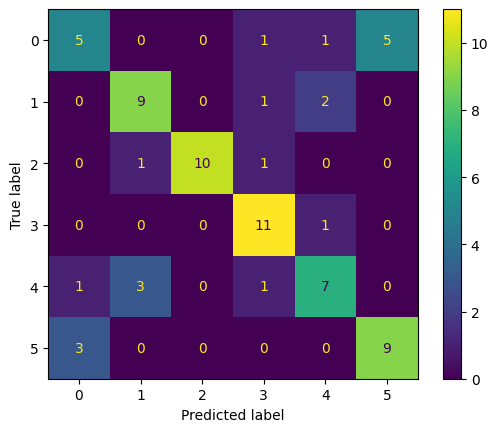

In [9]:
cm = confusion_matrix(res_train_pytorch["labels"], res_train_pytorch["predictions"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()